<a href="https://colab.research.google.com/github/LC1332/Speaker-Grouping/blob/main/notebook/%E9%AB%98%E7%BD%AE%E4%BF%A1%E5%BA%A6%E8%81%9A%E7%B1%BB%E5%AE%9E%E9%AA%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- [ ] 同时载入多个parquet
- [ ] 重构置信度计算程序，计算每个parquet样本的置信度
- [ ] 对于的高置信度，测试仅使用高置信度样本进行聚类的结果

# 载入parquet

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
!ls /content/drive/MyDrive/Speaker/feature

haruhi_03_feature.parquet     亮剑12.parquet  亮剑15.parquet
liangjian_10_feature.parquet  亮剑13.parquet  亮剑20.parquet


In [63]:
import pandas as pd

test_paths = [
    '/content/drive/MyDrive/Speaker/feature/haruhi_03_feature.parquet',
    '/content/drive/MyDrive/Speaker/feature/liangjian_10_feature.parquet',
]

# Parquet 文件的路径列表
train_paths = [
    '/content/drive/MyDrive/Speaker/feature/亮剑12.parquet',
    '/content/drive/MyDrive/Speaker/feature/亮剑13.parquet',
    '/content/drive/MyDrive/Speaker/feature/亮剑15.parquet',
    '/content/drive/MyDrive/Speaker/feature/亮剑20.parquet'
]

def load_datas_from_paths( paths ):
    datas = []
    for path in paths:
        df = pd.read_parquet(path)
        datas.append(df)
    return datas

train_datas = load_datas_from_paths(train_paths)
test_datas = load_datas_from_paths(test_paths)

# 过滤无标签数据

In [77]:
import numpy as np

def filter_data(data):
    # 去除人物为 'None' 的数据
    filtered_data = data[data['人物'].notna() & (data['人物'] != 'None')]

    # 去除 audio_feature 为 [] 的数据
    filtered_data = filtered_data[filtered_data['audio_feature'].apply(len) > 0]

    # Concat audio_feature 和 visual_feature 成为新的一列 av_feature
    # 确保特征是 Numpy 数组并合并它们
    filtered_data['av_feature'] = filtered_data.apply(lambda row: np.concatenate((row['audio_feature'], row['visual_feature'])), axis=1)

    return filtered_data



train_datas = [filter_data(data) for data in train_datas]
test_datas = [filter_data(data) for data in test_datas]

In [78]:
#@title 定义calculate_confidences(audio_features_matrix, speaker_labels)

import numpy as np
from sklearn.neighbors import NearestNeighbors

def calculate_confidences(audio_features_matrix, speaker_labels, sample_prob=0.1, sample_size=2, n_neighbors=25):
    # 计算 L2 范数
    norms = np.linalg.norm(audio_features_matrix, axis=1, keepdims=True)
    # 归一化特征矩阵
    normalized_audio_features_matrix = audio_features_matrix / norms
    # 创建并拟合模型
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(normalized_audio_features_matrix)
    # 获取近邻
    distances, indices = knn.kneighbors(normalized_audio_features_matrix)

    def compute_false_prob(is_correct):
        n = len(is_correct)
        p = [[0.0 for _ in range(sample_size + 1)] for _ in range(n + 1)]
        exit_prob = [0.0 for _ in range(n+1)]

        p[0][0] = 1.0
        for i in range(1, n + 1):
            exit_prob[i] = exit_prob[i - 1]
            p[i][sample_size] = p[i - 1][sample_size]

            for l in range(0, sample_size):
                if is_correct[i - 1]:
                    p[i][l] = p[i - 1][l] * (1 - sample_prob)
                    exit_prob[i] += p[i - 1][l] * sample_prob
                else:
                    p[i][l] = p[i - 1][l] * (1 - sample_prob)
                    if l > 0:
                        p[i][l] += p[i - 1][l - 1] * sample_prob

            if not is_correct[i - 1]:
                p[i][sample_size] += p[i - 1][sample_size - 1] * sample_prob

        return p[n][sample_size]

    confidences = []
    n = len(indices)
    for i in range(n):
        speaker_i = speaker_labels[i]
        indice = indices[i][1:]  # 排除自身
        speakers = [speaker_labels[j] for j in indice]
        is_correct = [speaker_i == speaker for speaker in speakers]
        confidence = 1 - compute_false_prob(is_correct)
        confidences.append(confidence)

    return confidences



In [79]:
def add_confidence_column(datas):
    for data in datas:
        # 根据 'audio_feature' 列创建特征矩阵
        audio_features_matrix = np.stack(data['audio_feature'].values)

        # 获取发言者标签列表
        speaker_labels = data['人物'].tolist()

        # 计算 confidence 值
        confidences = calculate_confidences(audio_features_matrix, speaker_labels)

        # 将计算得到的 confidence 列添加到 DataFrame
        data['confidence'] = confidences

# 应用到 train_datas 和 test_datas
add_confidence_column(train_datas)
add_confidence_column(test_datas)

# 合并training

In [80]:
import pandas as pd

# 假设 train_datas 是一个包含多个 DataFrame 的列表
combined_train_data = pd.concat(train_datas, ignore_index=True)

# 显示合并后的 DataFrame 的一些信息，确保合并正确
print(combined_train_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141 entries, 0 to 3140
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   人物               3141 non-null   object 
 1   人物台词             3141 non-null   object 
 2   开始时间             3141 non-null   object 
 3   结束时间             3141 non-null   object 
 4   audio_file       3141 non-null   object 
 5   screenshot_file  3141 non-null   object 
 6   visual_feature   3141 non-null   object 
 7   audio_feature    3141 non-null   object 
 8   confidence       3141 non-null   float64
 9   av_feature       3141 non-null   object 
dtypes: float64(1), object(9)
memory usage: 245.5+ KB
None


# 定义特征

In [82]:
feature_to_estimate = "av_feature"

In [83]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

def train_confidence_model(data):
    # 从筛选后的 DataFrame 中提取特征和置信度
    features = np.array(data[feature_to_estimate].tolist())
    confidences = data['confidence'].tolist()

    # 拆分数据集，取 1/10 作为测试集
    # X_train, X_test, y_train, y_test = train_test_split(features, confidences, test_size=0.1, random_state=42)
    X_train = features
    y_train = confidences

    # 建立神经网络回归模型
    # 设置了两个隐层，每个层10个节点
    model = MLPRegressor(hidden_layer_sizes=(10, 10), activation='relu', max_iter=500)

    # 训练模型
    model.fit(X_train, y_train)

    # 返回训练好的模型
    return model

In [84]:
confidence_model = train_confidence_model(combined_train_data)

In [85]:
def estimate_confidence( test_data , confidence_model ):
    # 提取每个 DataFrame 中的 audio_feature 列，并转换为适合模型输入的格式
    features = np.array(test_data[feature_to_estimate].tolist())

    # 使用模型预测 confidence
    estimated_confidences = confidence_model.predict(features)

    # 将预测结果添加为新列
    test_data['estimated_confidence'] = estimated_confidences

    return test_data

test_datas = [estimate_confidence(data, confidence_model) for data in test_datas]

# 获得层次聚类的准确率

In [86]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster
from collections import defaultdict

def execute_clustering_and_evaluation(inference_data, sim_threshold=0.55):
    # 提取人物列
    speakers = inference_data['人物'].tolist()
    # 删除人物列
    data = inference_data.drop(columns=['人物'])

    # 层次聚类
    cluster_labels = hierarchical_clustering(data, sim_threshold=sim_threshold)

    # 计算精确度和召回率
    results = calculate_pairwise_precision_recall(cluster_labels, speakers)
    return results

def hierarchical_clustering(data, sim_threshold=0.55, feature_name="audio_feature"):
    # Extract audio features
    features = np.stack(data[feature_name].values)
    # Compute pairwise distances using cosine metric
    distances = pdist(features, metric='cosine')
    # Perform hierarchical clustering
    Z = linkage(distances, method='average')
    # Form clusters based on similarity threshold
    distance_threshold = 1 - sim_threshold
    cluster_labels = fcluster(Z, t=distance_threshold, criterion='distance')
    # Create a new mapping for labels to make them continuous from 0
    unique_labels = np.unique(cluster_labels)
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
    continuous_labels = [label_mapping[label] for label in cluster_labels]
    return continuous_labels

def calculate_pairwise_precision_recall(cluster_labels, speakers):
    """
    Calculate pairwise precision and recall for clustering results based on speaker labels.

    :param cluster_labels: List of integers, cluster assignments for each sample.
    :param speakers: List of strings, speaker identifiers for each sample.
    :return: Dictionary containing 'precision' and 'recall'.
    """
    # Group indices by cluster and by speaker
    clusters = defaultdict(list)
    speaker_groups = defaultdict(list)

    for index, (cluster, speaker) in enumerate(zip(cluster_labels, speakers)):
        clusters[cluster].append(speaker)
        speaker_groups[speaker].append(index)

    # Calculate True Positives (TP): sum of intra-cluster possible pairs of same speaker
    TP = 0
    for cluster, members in clusters.items():
        speaker_count = defaultdict(int)
        for speaker in members:
            speaker_count[speaker] += 1
        # print(speaker_count)
        for count in speaker_count.values():
            TP += count * (count - 1) / 2

    # Calculate True Positives + False Positives (TP + FP): sum of intra-cluster possible pairs
    TP_FP = 0
    for cluster, members in clusters.items():
        count = len(members)
        TP_FP += count * (count - 1) / 2

    # Calculate True Positives + False Negatives (TP + FN): sum of all possible pairs of same speaker across clusters
    TP_FN = 0
    for speaker, indices in speaker_groups.items():
        count = len(indices)
        TP_FN += count * (count - 1) / 2

    # Compute precision and recall
    precision = TP / TP_FP if TP_FP > 0 else 0
    recall = TP / TP_FN if TP_FN > 0 else 0

    return {'precision': precision, 'recall': recall, 'TP': TP, 'TP_FP':TP_FP, 'TP_FN':TP_FN}


test_results = execute_clustering_and_evaluation(test_datas[0], sim_threshold=0.4)
print(test_results)


{'precision': 0.9862203485811364, 'recall': 0.6888761921504857, 'TP': 15674.0, 'TP_FP': 15893.0, 'TP_FN': 22753.0}


# 使用置信度作为filter

In [87]:
import pandas as pd
from tqdm import tqdm

# 初始化一个空的 DataFrame 用于存储结果
results_df = pd.DataFrame(columns=['test_id', 'conf_level', 'sim_threshold', 'precision', 'recall', 'TP', 'TP_FP', 'TP_FN'])


test_table = test_datas[0]

query_results = []
for conf_level in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for sim_threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        query_results.append((conf_level, sim_threshold))

from tqdm import tqdm

for test_id in range(len(test_datas)):
    test_table = test_datas[test_id]

    for conf_level, sim_threshold in tqdm(query_results):

        filtered_table = test_table[test_table['estimated_confidence'] >= conf_level]

        test_results = execute_clustering_and_evaluation( filtered_table , sim_threshold=sim_threshold)

        # 准备一个新的 DataFrame 行
        new_row = pd.DataFrame({
            'test_id': [test_id],
            'conf_level': [conf_level],
            'sim_threshold': [sim_threshold],
            'precision': [test_results['precision']],
            'recall': [test_results['recall']],
            'TP': [test_results['TP']],
            'TP_FP': [test_results['TP_FP']],
            'TP_FN': [test_results['TP_FN']]
        })

        # 使用 concat 方法添加新行
        results_df = pd.concat([results_df, new_row], ignore_index=True)

100%|██████████| 63/63 [00:02<00:00, 24.35it/s]


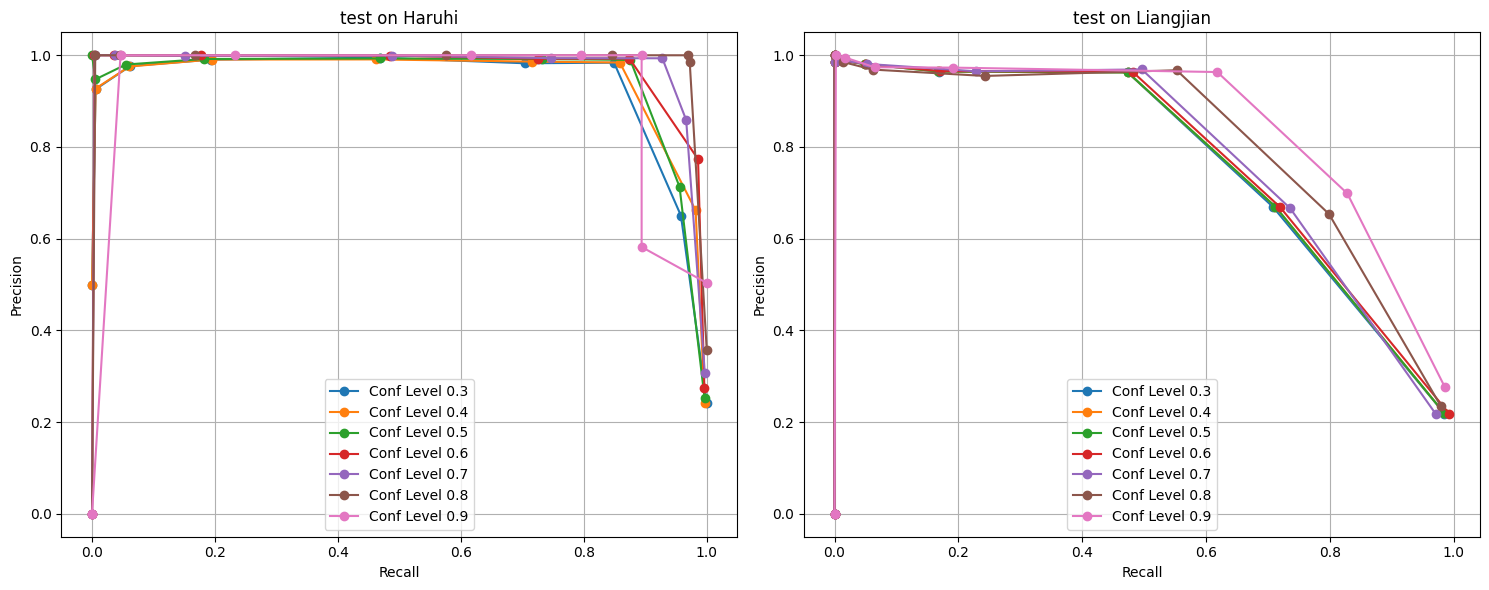

In [88]:
import matplotlib.pyplot as plt

visual_titles = ['test on Haruhi', 'test on Liangjian']

# 准备画两个子图，一行两列
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 创建 1 行 2 列的子图布局，指定整体图形大小

# 通过循环来避免代码重复，依次处理 visual_test_id = 0 和 visual_test_id = 1
for i, visual_test_id in enumerate([0, 1]):
    # 选择 test_id == visual_test_id 的数据
    visual_data = results_df[results_df['test_id'] == visual_test_id]

    # 确定所有 unique conf_level
    unique_conf_levels = visual_data['conf_level'].unique()

    # 遍历每个 conf_level
    for conf_level in unique_conf_levels:
        # 选取当前 conf_level 下的数据
        conf_data = visual_data[visual_data['conf_level'] == conf_level]

        # 排序数据，确保 sim_threshold 从小到大
        conf_data = conf_data.sort_values(by='sim_threshold')

        # 绘制 precision-recall 曲线
        axes[i].plot(conf_data['recall'], conf_data['precision'], marker='o', label=f'Conf Level {conf_level}')

    # 设置当前子图的标题、坐标轴标签和图例
    axes[i].set_title(visual_titles[visual_test_id])
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].legend()
    axes[i].grid(True)  # 开启网格

# 展示整个图形
plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
plt.show()
